### Ordinary least squares Linear Regression. LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from preprocessing import mean_and_std
from regression_models import dosomething

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
outliers_df = pd.read_csv('geocoded.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    2400 non-null   int64  
 1   bed             2400 non-null   float64
 2   bath            2400 non-null   float64
 3   acre_lot        2400 non-null   float64
 4   zip_code        2400 non-null   float64
 5   house_size      2400 non-null   float64
 6   prev_sold_date  2400 non-null   object 
 7   price           2400 non-null   float64
 8   prev_sold_year  2400 non-null   int64  
 9   zip_code_str    2400 non-null   int64  
 10  latitude        2400 non-null   float64
 11  longitude       2400 non-null   float64
 12  county          2400 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 243.9+ KB


#### Find the county of that has the most houses.

In [4]:
groupby_county = outliers_df.groupby(["county"])["county"].count().sort_values(ascending=False)
groupby_county_df = pd.DataFrame(groupby_county).rename(columns={"county":"count"}).reset_index()
first_county = groupby_county_df.iloc[0]["county"]
first_county

7

#### Find the rows of the county that has the most houses.

In [5]:
one_county_df = outliers_df[outliers_df["county"].isin([first_county])]

In [6]:
one_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 296 to 871
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    195 non-null    int64  
 1   bed             195 non-null    float64
 2   bath            195 non-null    float64
 3   acre_lot        195 non-null    float64
 4   zip_code        195 non-null    float64
 5   house_size      195 non-null    float64
 6   prev_sold_date  195 non-null    object 
 7   price           195 non-null    float64
 8   prev_sold_year  195 non-null    int64  
 9   zip_code_str    195 non-null    int64  
 10  latitude        195 non-null    float64
 11  longitude       195 non-null    float64
 12  county          195 non-null    int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 21.3+ KB


#### Create an object to pass to the function that will normalize the data

In [7]:
params = {
    "data":one_county_df,
    "features_a":["prev_sold_year","county","latitude","longitude"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
#normalize_df = mean_and_std(params)
normalize_df = one_county_df
normalize_df.tail()

,Unnamed: 0.1,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude,county
867,867,3.0,1.0,0.27,6111.0,1142.0,2018-12-17,249900.0,2018,6111,41.686993,-72.730839,7
868,868,3.0,2.0,0.50,6111.0,1152.0,2019-07-25,129900.0,2019,6111,41.686993,-72.730839,7
869,869,2.0,2.0,0.17,6111.0,1364.0,2020-05-27,219900.0,2020,6111,41.686993,-72.730839,7
870,870,3.0,2.0,0.18,6111.0,1152.0,2019-05-23,65000.0,2019,6111,41.686993,-72.730839,7
871,871,1.0,1.0,0.17,6111.0,810.0,2021-10-05,129900.0,2021,6111,41.686993,-72.730839,7


#### Create a variable for the correlation of the normalized data

In [8]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.042792
bed               0.250492
bath              0.669163
house_size        0.560525
prev_sold_year   -0.023553
price             1.000000
Name: price, dtype: float64

#### Display a Heatmap with the correlated data

Text(0.5, 1.0, 'Correlation Between Variables')

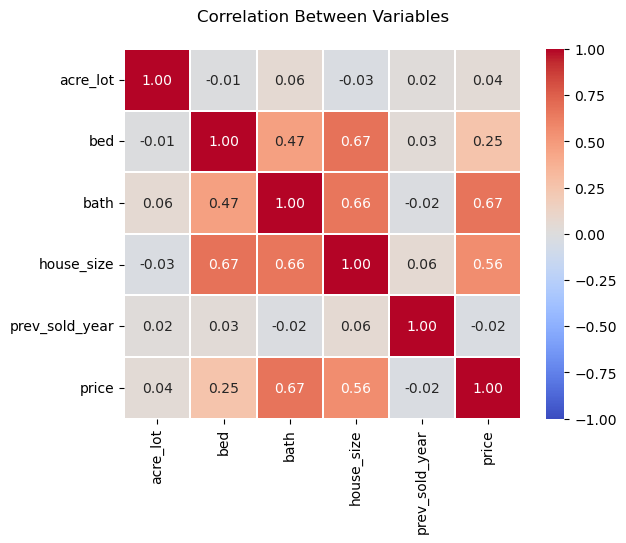

In [9]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

#### Create a variable to hold the features that correlate with the price feature between 0.20 and 0.80

In [10]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'bed', 'bath', 'house_size']


#### Create common variables to store frequently used values.

In [11]:
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [12]:
X = normalize_df[features]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [13]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [14]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [15]:
linear_bp = dosomething("linear","Best Params", normalize_df, features, "price")
results_dict_append(linear_bp["results"])
linear_bp_predict = linear_bp["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Best Params EVS = 0.452133035
Best Params MSE = 9,300,191,238.785624
Best Params MAE = 72,823.319033
Best Params R2 = 0.430784
Best Params Fit Time = 0.0


### SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter.

In [16]:
linear_sfm = dosomething("linear","Select From Model", normalize_df, features, "price")
results_dict_append(linear_sfm["results"])
linear_sfm_predict = linear_sfm["predictions"]

The selected features are: ['longitude']
Select From Model EVS = 0.082817228
Select From Model MSE = 15,018,009,024.354263
Select From Model MAE = 94,696.451905
Select From Model R2 = 0.080826
Select From Model Fit Time = 0.0008096694946289062


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator.

In [17]:
linear_sfs = dosomething("linear","Sequential Feature Selector", normalize_df, features, "price")
results_dict_append(linear_sfs["results"])
linear_sfs_predict = linear_sfs["predictions"]

The selected features are: ['latitude', 'bed', 'bath', 'house_size']
Sequential Feature Selector EVS = 0.398619563
Sequential Feature Selector MSE = 10,270,788,087.659365
Sequential Feature Selector MAE = 76,969.424529
Sequential Feature Selector R2 = 0.371379
Sequential Feature Selector Fit Time = 0.0


### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [18]:
linear_rfe = dosomething("linear","Recursive Feature Elimination", normalize_df, features, "price")
results_dict_append(linear_rfe["results"])
linear_rfe_predict = linear_rfe["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath']
Recursive Feature Elimination EVS = 0.448799034
Recursive Feature Elimination MSE = 9,278,444,723.981607
Recursive Feature Elimination MAE = 71,452.952334
Recursive Feature Elimination R2 = 0.432115
Recursive Feature Elimination Fit Time = 0.0006426334381103516


### Use Grid Search CV to find the best Parameters for Polynomial Regression

In [19]:
pipeline_gscv = Pipeline([
    ('poly_features', PolynomialFeatures()), 
    ('poly_model', LinearRegression())
])

pipeline_params={"poly_features__degree":[1,2,3,4,5],"poly_features__include_bias":[False],"poly_model__fit_intercept":[True]}
grid_searchcv = GridSearchCV(pipeline_gscv, param_grid=pipeline_params, cv=5, verbose=1)

In [20]:
grid_searchcv.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly_features', PolynomialFeatures()),
                                       ('poly_model', LinearRegression())]),
             param_grid={'poly_features__degree': [1, 2, 3, 4, 5],
                         'poly_features__include_bias': [False],
                         'poly_model__fit_intercept': [True]},
             verbose=1)

In [21]:
print(f"Best parameters found: {grid_searchcv.best_params_}")

Best parameters found: {'poly_features__degree': 2, 'poly_features__include_bias': False, 'poly_model__fit_intercept': True}


In [22]:
pipeline_params = {}
for what in grid_searchcv.best_params_:
    if pipeline_params.get(what) == None:
        pipeline_params[what] = []
    pipeline_params[what].append(grid_searchcv.best_params_[what])
pipeline_params

{'poly_features__degree': [2],
 'poly_features__include_bias': [False],
 'poly_model__fit_intercept': [True]}

In [23]:
poly_bp = dosomething("linear","PolynomialFeatures", normalize_df, features, "price", pipeline_params)
results_dict_append(poly_bp["results"])
poly_predict = poly_bp["predictions"]

PolynomialFeatures EVS = 0.541773228
PolynomialFeatures MSE = 7,683,112,979.457983
PolynomialFeatures MAE = 66,465.137555
PolynomialFeatures R2 = 0.529757
PolynomialFeatures Fit Time = 0.0033788681030273438


#### Graphing the results works best when the data is provided in a DataFrame.

In [24]:
poly_predict_df = pd.DataFrame(poly_predict).reset_index()
poly_predict_df.rename(columns={0: "prediction"},inplace=True)

linear_bp_predict = pd.DataFrame(linear_bp_predict).reset_index()
linear_bp_predict.rename(columns={0: "prediction"},inplace=True)

linear_sfm_predict_df = pd.DataFrame(linear_sfm_predict).reset_index()
linear_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

linear_sfs_predict_df = pd.DataFrame(linear_sfs_predict).reset_index()
linear_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

linear_rfe_predict_df = pd.DataFrame(linear_rfe_predict).reset_index()
linear_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

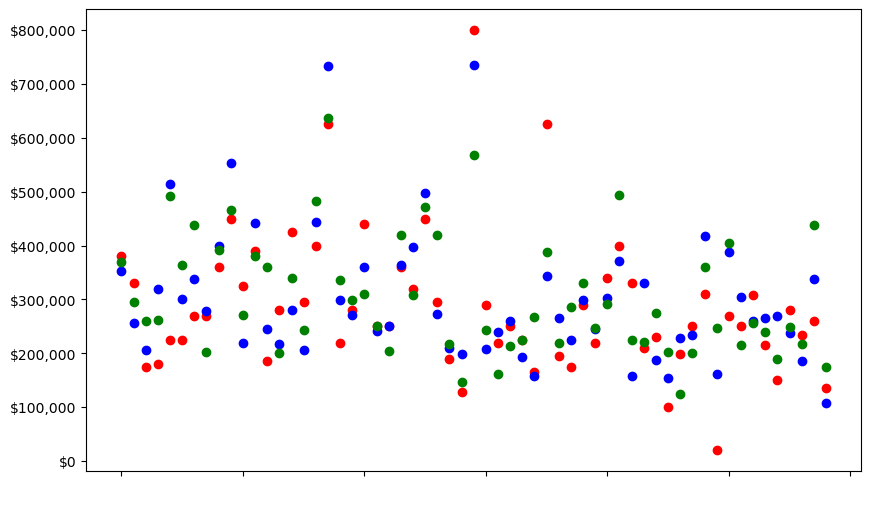

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(poly_predict_df.index,poly_predict_df["prediction"], color="blue")
plt.scatter(linear_bp_predict.index,linear_bp_predict["prediction"], color="green")
plt.show()

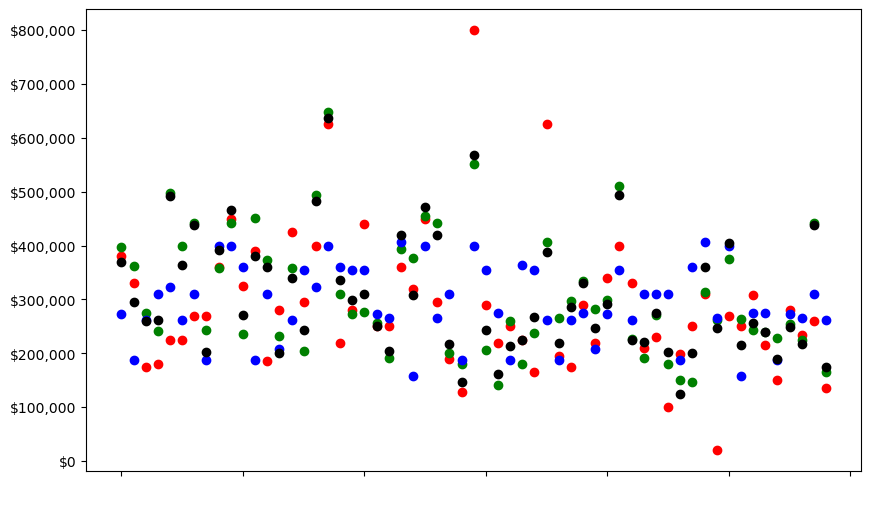

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(linear_sfs_predict_df.index,linear_sfs_predict_df["prediction"], color="green")
plt.scatter(linear_sfm_predict_df.index,linear_sfm_predict_df["prediction"], color="blue")
plt.scatter(linear_bp_predict.index,linear_bp_predict["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [27]:
results_dict

{'model': ['Best Params',
  'Select From Model',
  'Sequential Feature Selector',
  'Recursive Feature Elimination',
  'PolynomialFeatures'],
 'explained variance score': ['0.452133035',
  '0.082817228',
  '0.398619563',
  '0.448799034',
  '0.541773228'],
 'mae score': ['72,823.319033',
  '94,696.451905',
  '76,969.424529',
  '71,452.952334',
  '66,465.137555'],
 'mse score': ['9,300,191,238.785624',
  '15,018,009,024.354263',
  '10,270,788,087.659365',
  '9,278,444,723.981607',
  '7,683,112,979.457983'],
 'r2 score': ['0.430784', '0.080826', '0.371379', '0.432115', '0.529757'],
 'mean fit time': [0.0,
  0.0008096694946289062,
  0.0,
  0.0006426334381103516,
  0.0033788681030273438]}

In [28]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Best Params,0.452133035,"72,823.319033","9,300,191,238.785624",0.430784,0.000000
Select From Model,0.082817228,"94,696.451905","15,018,009,024.354263",0.080826,0.000810
Sequential Feature Selector,0.398619563,"76,969.424529","10,270,788,087.659365",0.371379,0.000000
Recursive Feature Elimination,0.448799034,"71,452.952334","9,278,444,723.981607",0.432115,0.000643
PolynomialFeatures,0.541773228,"66,465.137555","7,683,112,979.457983",0.529757,0.003379
